In [1]:
!pip install speechbrain torchaudio scipy scikit-learn

Starting Phase 2: Temporal Modeling & Fine-tuning
✅ CUDA is available!
🚀 Using GPU: Tesla P100-PCIE-16GB
💾 GPU Memory: 17.1 GB
🔥 CUDA Version: 12.4
🎯 Initializing ECAPA-TDNN on cuda:0
🎯 Initializing ECAPA-TDNN on cuda:0
✅ Loaded SpeechBrain ECAPA-TDNN model
🔧 Setting up temporal modeling components...
✅ Temporal components initialized
Using roadmap baseline accuracy: 0.774

Discovering VoxConverse dataset files...
Found VoxConverse at: /kaggle/input/voxconverse-dataset
Found 216 files for Phase 2 testing

Processing Batch 1/11
Files in this batch: 20

Processing file 1/216
File: bwzyf
Enhanced processing: bwzyf.wav
🎵 Loading audio: bwzyf.wav
📏 Audio duration: 80.17s
🔄 Extracting embeddings from 78 windows...
✅ Extracted 78 valid embeddings
📊 Embedding shape: (78, 192)
🔄 Applying temporal modeling...
✅ Temporal smoothing applied: (78, 192) -> (78, 192)
🎙️  VAD detected 4580/5011 active frames
Oracle speaker count: 4
📊 Embedding shape: (78, 192)
🧹 Cleaning embeddings...
✅ Cleaned embeddi

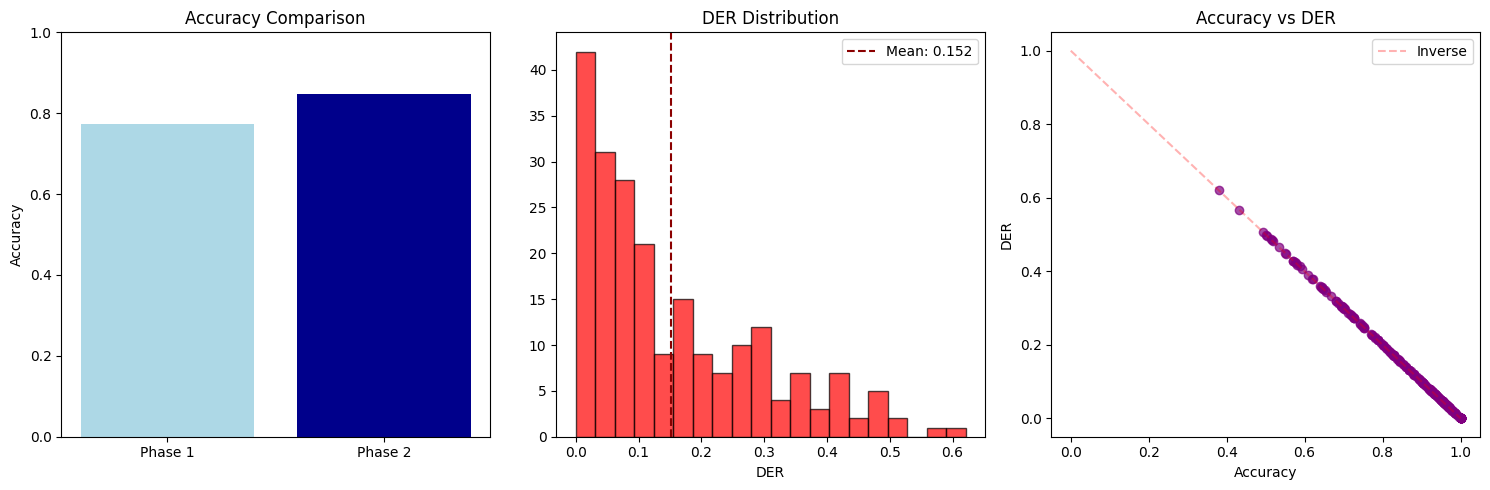

In [2]:
# Phase 2: Temporal Modeling & Fine-tuning Speaker Diarization
# Target: 80-85% accuracy through temporal sequence modeling

import glob
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from sklearn.cluster import SpectralClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset

warnings.filterwarnings("ignore")


def setup_device():
    """Setup device with comprehensive CUDA checking for Kaggle"""
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        print(f"✅ CUDA is available!")
        print(f"🚀 Using GPU: {torch.cuda.get_device_name(0)}")
        print(
            f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB"
        )
        print(f"🔥 CUDA Version: {torch.version.cuda}")

        # Set memory allocation strategy for Kaggle
        torch.cuda.empty_cache()
        if hasattr(torch.cuda, "set_memory_fraction"):
            torch.cuda.set_memory_fraction(0.8)  # Use 80% of GPU memory

    else:
        device = torch.device("cpu")
        print("⚠️  CUDA not available, using CPU")
        print("💡 Consider enabling GPU in Kaggle: Settings -> Accelerator -> GPU")

    return device


class ECAPAEmbeddingExtractor:
    def __init__(self, device):
        self.device = device
        self.model = None
        self.sample_rate = 16000
        print(f"🎯 Initializing ECAPA-TDNN on {device}")

    def load_pretrained_model(self):
        """Load pre-trained ECAPA-TDNN model with error handling"""
        try:
            # Try SpeechBrain ECAPA-TDNN first
            from speechbrain.pretrained import EncoderClassifier

            self.model = EncoderClassifier.from_hparams(
                source="speechbrain/spkrec-ecapa-voxceleb",
                savedir="pretrained_models/spkrec-ecapa-voxceleb",
                run_opts={"device": str(self.device)},
            )
            print("✅ Loaded SpeechBrain ECAPA-TDNN model")
            return True

        except Exception as e:
            print(f"⚠️  SpeechBrain model failed: {e}")
            try:
                # Fallback to basic embedding extraction
                self.model = self._create_basic_cnn_model()
                print("✅ Loaded fallback CNN model")
                return True
            except Exception as e2:
                print(f"❌ All models failed: {e2}")
                return False

    def _create_basic_cnn_model(self):
        """Fallback CNN model if ECAPA-TDNN fails"""
        import torch.nn as nn

        class BasicSpeakerCNN(nn.Module):
            def __init__(self):
                super().__init__()
                self.conv1 = nn.Conv1d(80, 128, kernel_size=3, padding=1)
                self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
                self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
                self.pool = nn.AdaptiveAvgPool1d(1)
                self.fc = nn.Linear(512, 192)  # 192-dim embeddings
                self.dropout = nn.Dropout(0.1)

            def forward(self, x):
                x = torch.relu(self.conv1(x))
                x = torch.relu(self.conv2(x))
                x = torch.relu(self.conv3(x))
                x = self.pool(x).squeeze(-1)
                x = self.dropout(x)
                return torch.nn.functional.normalize(self.fc(x), p=2, dim=1)

        model = BasicSpeakerCNN().to(self.device)
        return model

    def extract_features(self, audio_file, window_size=3.0, hop_size=1.0):
        """Extract MFCC features with sliding window"""
        try:
            # Load audio
            waveform, sr = torchaudio.load(audio_file)

            # Resample if necessary
            if sr != self.sample_rate:
                resampler = torchaudio.transforms.Resample(sr, self.sample_rate)
                waveform = resampler(waveform)

            # Convert to mono if stereo
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)

            # Extract MFCC features
            mfcc_transform = torchaudio.transforms.MFCC(
                sample_rate=self.sample_rate,
                n_mfcc=80,
                melkwargs={"n_fft": 512, "hop_length": 256, "n_mels": 80},
            )

            mfcc = mfcc_transform(waveform).squeeze(0).transpose(0, 1)  # (time, mfcc)

            return mfcc.numpy()

        except Exception as e:
            print(f"❌ Feature extraction failed for {audio_file}: {e}")
            return None

    def extract_embeddings(self, audio_file, window_size=3.0, hop_size=1.0):
        """Extract speaker embeddings using sliding window with robust error handling"""
        embeddings = []
        timestamps = []

        try:
            print(f"🎵 Loading audio: {os.path.basename(audio_file)}")

            # Load and preprocess audio
            waveform, sr = torchaudio.load(audio_file)

            if sr != self.sample_rate:
                resampler = torchaudio.transforms.Resample(sr, self.sample_rate)
                waveform = resampler(waveform)

            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)

            # Check audio length
            duration = waveform.shape[1] / self.sample_rate
            print(f"📏 Audio duration: {duration:.2f}s")

            if duration < window_size:
                print(
                    f"⚠️  Audio too short ({duration:.2f}s < {window_size}s), using entire audio"
                )
                window_size = max(1.0, duration * 0.8)  # Use 80% of audio
                hop_size = window_size / 2  # 50% overlap

            # Sliding window extraction
            window_samples = int(window_size * self.sample_rate)
            hop_samples = int(hop_size * self.sample_rate)

            num_windows = max(1, (waveform.shape[1] - window_samples) // hop_samples + 1)
            print(f"🔄 Extracting embeddings from {num_windows} windows...")

            for i in range(num_windows):
                start = i * hop_samples
                end = min(start + window_samples, waveform.shape[1])

                # Ensure minimum window size
                if end - start < self.sample_rate:  # At least 1 second
                    continue

                segment = waveform[:, start:end].to(self.device)

                try:
                    if hasattr(self.model, "encode_batch"):
                        # SpeechBrain model
                        with torch.no_grad():
                            # Ensure proper tensor format for SpeechBrain
                            if segment.dim() == 2:
                                segment = segment.squeeze(0)  # Remove batch dimension if present
                            segment = segment.unsqueeze(0)  # Add batch dimension

                            embedding = self.model.encode_batch(segment)

                            # Handle different output formats
                            if isinstance(embedding, torch.Tensor):
                                embedding = embedding.cpu().numpy().flatten()
                            else:
                                embedding = np.array(embedding).flatten()
                    else:
                        # Fallback model - extract MFCC and use CNN
                        mfcc_transform = torchaudio.transforms.MFCC(
                            sample_rate=self.sample_rate, n_mfcc=80
                        ).to(self.device)

                        with torch.no_grad():
                            mfcc = mfcc_transform(segment.unsqueeze(0))  # Add batch dim
                            embedding = self.model(mfcc).cpu().numpy().flatten()

                    # Validate embedding
                    if not np.isnan(embedding).any() and not np.isinf(embedding).any():
                        embeddings.append(embedding)
                        timestamps.append(start / self.sample_rate)
                    else:
                        print(
                            f"⚠️  Invalid embedding at {start / self.sample_rate:.2f}s"
                        )

                except Exception as e:
                    print(
                        f"⚠️  Failed to extract embedding at {start / self.sample_rate:.2f}s: {e}"
                    )
                    continue

            embeddings = np.array(embeddings)
            timestamps = np.array(timestamps)

            print(f"✅ Extracted {len(embeddings)} valid embeddings")
            print(f"📊 Embedding shape: {embeddings.shape}")

            if len(embeddings) == 0:
                print("❌ No valid embeddings extracted!")
                return np.array([]), np.array([])

        except Exception as e:
            print(f"❌ Embedding extraction failed for {audio_file}: {e}")
            return np.array([]), np.array([])

        return embeddings, timestamps


class NeuralClusteringPipeline:
    def __init__(self, device):
        self.device = device
        self.extractor = ECAPAEmbeddingExtractor(device)
        self.scaler = StandardScaler()

    def initialize(self):
        """Initialize the embedding extractor"""
        return self.extractor.load_pretrained_model()

    def process_audio_file_enhanced(self, audio_file, rttm_file=None):
        """Enhanced processing with temporal modeling"""
        print(f"Enhanced processing: {os.path.basename(audio_file)}")
    
        # Extract embeddings with temporal modeling
        embeddings, timestamps = (
            self.extractor.extract_embeddings_with_temporal_modeling(audio_file)
        )
    
        if embeddings.size == 0:
            return None
    
        # Voice Activity Detection
        vad_decisions = self.extractor.detect_voice_activity(audio_file)
    
        # Load ground truth if available
        ground_truth = None
        is_speech = None
        
        if rttm_file and os.path.exists(rttm_file):
            result = self.parse_rttm(rttm_file, timestamps)
            
            # Handle both old (single return) and new (tuple return) versions
            if result is not None:
                if isinstance(result, tuple) and len(result) == 2:
                    ground_truth, is_speech = result
                else:
                    # Old version - only labels returned
                    ground_truth = result
                    is_speech = None
    
        return {
            "embeddings": embeddings,
            "timestamps": timestamps,
            "ground_truth": ground_truth,
            "is_speech": is_speech,
            "vad_decisions": vad_decisions,
            "filename": os.path.basename(audio_file),
        }

    def parse_rttm(self, rttm_file, timestamps):
        """Parse RTTM file to get speaker labels for timestamps, with silence handling"""
        labels = []
        is_speech = []  # Track which frames are actually speech
    
        try:
            with open(rttm_file, "r") as f:
                rttm_lines = f.readlines()
    
            # Parse RTTM format
            speaker_segments = []
            for line in rttm_lines:
                parts = line.strip().split()
                if len(parts) >= 8 and parts[0] == "SPEAKER":
                    start_time = float(parts[3])
                    duration = float(parts[4])
                    end_time = start_time + duration
                    speaker_id = parts[7]
                    speaker_segments.append((start_time, end_time, speaker_id))
    
            # Map timestamps to speaker labels
            speaker_to_id = {}
            current_id = 0
    
            for timestamp in timestamps:
                assigned_speaker = None  # None = silence
                
                for start, end, speaker in speaker_segments:
                    if start <= timestamp <= end:
                        assigned_speaker = speaker
                        break
    
                if assigned_speaker is None:
                    # This is a silence frame
                    labels.append(-1)  # Use -1 to mark silence
                    is_speech.append(False)
                else:
                    # This is a speech frame
                    if assigned_speaker not in speaker_to_id:
                        speaker_to_id[assigned_speaker] = current_id
                        current_id += 1
                    
                    labels.append(speaker_to_id[assigned_speaker])
                    is_speech.append(True)
    
        except Exception as e:
            print(f"RTTM parsing failed: {e}")
            return None, None
    
        return np.array(labels), np.array(is_speech)

    def cluster_embeddings(self, embeddings, n_speakers=None, method="spectral"):
        """Advanced clustering with multiple algorithms and robust preprocessing"""
        if embeddings.size == 0:
            print("⚠️  Empty embeddings array")
            return np.array([])

        print(f"📊 Embedding shape: {embeddings.shape}")

        # Robust preprocessing to handle NaN/inf values
        embeddings_clean = self._clean_embeddings(embeddings)

        if embeddings_clean.size == 0:
            print("❌ No valid embeddings after cleaning")
            return np.array([])

        # Normalize embeddings
        try:
            embeddings_norm = self.scaler.fit_transform(embeddings_clean)
        except Exception as e:
            print(f"⚠️  Normalization failed: {e}, using raw embeddings")
            embeddings_norm = embeddings_clean

        # Estimate number of speakers if not provided
        if n_speakers is None:
            n_speakers = self.estimate_speakers(embeddings_norm)

        # Ensure we have enough samples for clustering
        if len(embeddings_norm) < n_speakers:
            print(
                f"⚠️  Not enough samples ({len(embeddings_norm)}) for {n_speakers} clusters"
            )
            n_speakers = max(1, min(2, len(embeddings_norm)))

        print(
            f"🎯 Clustering {len(embeddings_norm)} samples into {n_speakers} speakers using {method}"
        )

        # Apply clustering with error handling
        try:
            if method == "spectral":
                # Use nearest neighbors affinity to avoid invalid 'cosine' affinity
                clusterer = SpectralClustering(
                    n_clusters=n_speakers,
                    random_state=42,
                    affinity="nearest_neighbors",
                    n_neighbors=min(10, max(3, len(embeddings_norm) // 2)),
                    assign_labels="kmeans",
                )
            elif method == "agglomerative":
                from sklearn.cluster import AgglomerativeClustering

                clusterer = AgglomerativeClustering(
                    n_clusters=n_speakers, linkage="average", metric="cosine"
                )
            else:
                raise ValueError(f"Unknown method: {method}")

            labels = clusterer.fit_predict(embeddings_norm)
            print(
                f"✅ Clustering successful: {len(np.unique(labels))} clusters found"
            )
            return labels

        except Exception as e:
            print(f"❌ {method} clustering failed: {e}")
            print("🔄 Falling back to K-means clustering...")

            # Fallback to K-means which is more robust
            try:
                from sklearn.cluster import KMeans

                kmeans = KMeans(n_clusters=n_speakers, random_state=42, n_init=10)
                labels = kmeans.fit_predict(embeddings_norm)
                print(
                    f"✅ K-means fallback successful: {len(np.unique(labels))} clusters found"
                )
                return labels
            except Exception as e2:
                print(f"❌ K-means fallback also failed: {e2}")
                # Ultimate fallback - return alternating labels
                labels = np.tile(
                    np.arange(n_speakers),
                    len(embeddings_norm) // n_speakers + 1,
                )[: len(embeddings_norm)]
                print(f"⚠️  Using alternating pattern fallback")
                return labels

    def _clean_embeddings(self, embeddings):
        """Clean embeddings by removing NaN/inf values and zero vectors"""
        print(f"🧹 Cleaning embeddings...")

        # Check for NaN or inf values
        nan_mask = np.isnan(embeddings).any(axis=1)
        inf_mask = np.isinf(embeddings).any(axis=1)

        if nan_mask.any():
            print(f"⚠️  Found {nan_mask.sum()} samples with NaN values")
        if inf_mask.any():
            print(f"⚠️  Found {inf_mask.sum()} samples with inf values")

        # Remove problematic samples
        valid_mask = ~(nan_mask | inf_mask)
        embeddings_clean = embeddings[valid_mask]

        # Check for zero vectors (which can cause issues with cosine similarity)
        zero_mask = np.all(np.abs(embeddings_clean) < 1e-10, axis=1)
        if zero_mask.any():
            print(f"⚠️  Found {zero_mask.sum()} near-zero vectors")
            embeddings_clean = embeddings_clean[~zero_mask]

        # Add small noise to identical embeddings to avoid singular matrices
        if len(embeddings_clean) > 1:
            # Check for identical rows
            for i in range(len(embeddings_clean)):
                identical_mask = np.all(
                    np.abs(embeddings_clean - embeddings_clean[i]) < 1e-10, axis=1
                )
                if identical_mask.sum() > 1:
                    # Add small random noise to break ties
                    noise = np.random.normal(
                        0, 1e-8, embeddings_clean[identical_mask].shape
                    )
                    embeddings_clean[identical_mask] += noise

        print(
            f"✅ Cleaned embeddings: {len(embeddings)} → {len(embeddings_clean)} samples"
        )
        return embeddings_clean

    def estimate_speakers(self, embeddings, max_speakers=20):
        """Estimate optimal number of speakers using silhouette analysis with error handling"""
        if len(embeddings) < 4:
            print("Too few samples for speaker estimation, defaulting to 2")
            return 2
    
        best_score = -1
        best_n = 2
        max_clusters = min(max_speakers, len(embeddings) // 2, 20)  # Allow up to 20 speakers
    
        print(f"Estimating speakers (testing 2-{max_clusters} clusters)...")
    
        for n in range(2, max_clusters + 1):
            try:
                from sklearn.cluster import KMeans
    
                kmeans = KMeans(n_clusters=n, random_state=42, n_init=5)
                labels = kmeans.fit_predict(embeddings)
    
                if len(np.unique(labels)) > 1:
                    score = silhouette_score(embeddings, labels, metric="cosine")
                    
                    if score > best_score:
                        best_score = score
                        best_n = n
    
            except Exception as e:
                continue
    
        print(f"Estimated {best_n} speakers (silhouette score: {best_score:.3f})")
        return best_n


class DiarizationEvaluator:
    def __init__(self):
        pass

    def calculate_der(self, predicted_labels, true_labels, timestamps, is_speech=None):
        """Calculate proper DER with silence handling and component breakdown"""
        if len(predicted_labels) != len(true_labels) or len(predicted_labels) != len(timestamps):
            return {'der': float('inf'), 'fa_time': 0, 'miss_time': 0, 'error_time': 0, 'total_speech_time': 0}
        
        if len(timestamps) < 2:
            return {'der': 0.0, 'fa_time': 0, 'miss_time': 0, 'error_time': 0, 'total_speech_time': 0}
        
        from scipy.optimize import linear_sum_assignment
        
        # Calculate frame durations
        frame_durations = []
        for i in range(len(timestamps)):
            if i < len(timestamps) - 1:
                duration = timestamps[i + 1] - timestamps[i]
            else:
                if len(frame_durations) > 0:
                    duration = np.mean(frame_durations)
                else:
                    duration = 3.0
            frame_durations.append(duration)
        
        frame_durations = np.array(frame_durations)
        
        # If no speech mask provided, infer from true_labels
        if is_speech is None:
            is_speech = (true_labels >= 0)
            if not is_speech.any():
                return {'der': 0.0, 'fa_time': 0, 'miss_time': 0, 'error_time': 0, 'total_speech_time': 0}
        
        # Calculate total speech time from ground truth
        total_speech_time = frame_durations[is_speech].sum()
        
        if total_speech_time == 0:
            return {'der': 0.0, 'fa_time': 0, 'miss_time': 0, 'error_time': 0, 'total_speech_time': 0}
        
        # Only map speech frames with valid speaker labels
        speech_mask = is_speech & (true_labels >= 0) & (predicted_labels >= 0)
        
        if speech_mask.sum() == 0:
            missed = frame_durations[is_speech].sum()
            return {'der': 1.0, 'fa_time': 0, 'miss_time': missed, 'error_time': 0, 'total_speech_time': total_speech_time}
        
        # Build confusion matrix only for valid speech frames
        unique_pred = np.unique(predicted_labels[speech_mask])
        unique_true = np.unique(true_labels[speech_mask])
        
        confusion = np.zeros((len(unique_pred), len(unique_true)))
        
        for i, p_label in enumerate(unique_pred):
            for j, t_label in enumerate(unique_true):
                mask = speech_mask & (predicted_labels == p_label) & (true_labels == t_label)
                confusion[i, j] = frame_durations[mask].sum()
        
        # Optimal label mapping
        row_ind, col_ind = linear_sum_assignment(-confusion)
        
        label_mapping = {}
        for i, j in zip(row_ind, col_ind):
            label_mapping[unique_pred[i]] = unique_true[j]
        
        # Calculate DER components
        false_alarm_time = 0.0
        missed_speech_time = 0.0
        speaker_error_time = 0.0
        
        for i in range(len(predicted_labels)):
            duration = frame_durations[i]
            
            if is_speech[i]:
                if predicted_labels[i] < 0:
                    missed_speech_time += duration
                else:
                    pred_mapped = label_mapping.get(predicted_labels[i], -999)
                    if pred_mapped != true_labels[i]:
                        speaker_error_time += duration
            else:
                if predicted_labels[i] >= 0:
                    false_alarm_time += duration
        
        # DER formula
        der = (false_alarm_time + missed_speech_time + speaker_error_time) / total_speech_time
        
        if der < 0:
            der = 0.0
        
        return {
            'der': float(der),
            'fa_time': float(false_alarm_time),
            'miss_time': float(missed_speech_time),
            'error_time': float(speaker_error_time),
            'total_speech_time': float(total_speech_time)
        }

    def evaluate_clustering(self, predicted_labels, true_labels, timestamps=None):
        """Comprehensive evaluation metrics"""
        metrics = {}

        # Basic accuracy (with optimal label permutation)
        accuracy = self.calculate_optimal_accuracy(predicted_labels, true_labels)
        metrics["accuracy"] = accuracy

        # Adjusted Rand Index
        metrics["adjusted_rand_score"] = adjusted_rand_score(
            true_labels, predicted_labels
        )

        # DER if timestamps available
        if timestamps is not None:
            metrics["der"] = self.calculate_der(
                predicted_labels, true_labels, timestamps
            )

        # Silhouette score would need embeddings, skip for now
        return metrics

    def calculate_optimal_accuracy(self, predicted, true):
        """Calculate accuracy with optimal label alignment"""
        from scipy.optimize import linear_sum_assignment

        # Create confusion matrix
        unique_pred = np.unique(predicted)
        unique_true = np.unique(true)

        confusion = np.zeros((len(unique_pred), len(unique_true)))

        for i, p_label in enumerate(unique_pred):
            for j, t_label in enumerate(unique_true):
                confusion[i, j] = np.sum((predicted == p_label) & (true == t_label))

        # Find optimal assignment
        row_ind, col_ind = linear_sum_assignment(-confusion)

        # Calculate accuracy with optimal assignment
        correct = confusion[row_ind, col_ind].sum()
        total = len(predicted)

        return correct / total if total > 0 else 0.0

class TemporalSmoothingLSTM(nn.Module):
    """LSTM-based temporal smoothing for speaker embeddings"""

    def __init__(self, embedding_dim=192, hidden_dim=256, num_layers=2, dropout=0.1):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Bidirectional LSTM for temporal modeling
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True,
        )

        # Output projection to original embedding dimension
        self.projection = nn.Linear(hidden_dim * 2, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(embedding_dim)

    def forward(self, embeddings):
        """
        Args:
            embeddings: (batch_size, seq_len, embedding_dim)
        Returns:
            smoothed_embeddings: (batch_size, seq_len, embedding_dim)
        """
        # LSTM forward pass
        lstm_out, _ = self.lstm(embeddings)

        # Project back to original dimension
        output = self.projection(lstm_out)
        output = self.dropout(output)

        # Residual connection + layer norm
        output = self.layer_norm(output + embeddings)

        return output


class VoiceActivityDetector(nn.Module):
    """Neural Voice Activity Detection for preprocessing"""

    def __init__(self, input_dim=80, hidden_dim=128):
        super().__init__()
        self.conv1d = nn.Conv1d(input_dim, hidden_dim, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(
            hidden_dim, hidden_dim // 2, batch_first=True, bidirectional=True
        )
        self.classifier = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, features):
        """
        Args:
            features: (batch_size, seq_len, feature_dim)
        Returns:
            vad_probs: (batch_size, seq_len, 1)
        """
        # Conv1d expects (batch, channels, seq)
        x = features.transpose(1, 2)
        x = F.relu(self.conv1d(x))
        x = x.transpose(1, 2)

        # LSTM
        x, _ = self.lstm(x)
        x = self.dropout(x)

        # Classification
        vad_probs = torch.sigmoid(self.classifier(x))
        return vad_probs


class SpeakerChangeDetector(nn.Module):
    """Neural speaker change point detection"""

    def __init__(self, embedding_dim=192, hidden_dim=128):
        super().__init__()
        # Compare adjacent embeddings
        self.similarity_net = nn.Sequential(
            nn.Linear(embedding_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1),
        )

    def forward(self, embeddings):
        """
        Args:
            embeddings: (batch_size, seq_len, embedding_dim)
        Returns:
            change_probs: (batch_size, seq_len-1, 1)
        """
        batch_size, seq_len, embed_dim = embeddings.shape

        if seq_len < 2:
            return torch.zeros(batch_size, 0, 1, device=embeddings.device)

        # Create pairs of adjacent embeddings
        embed_current = embeddings[:, :-1, :]  # All except last
        embed_next = embeddings[:, 1:, :]  # All except first

        # Concatenate pairs
        pairs = torch.cat([embed_current, embed_next], dim=-1)

        # Predict change probability
        change_probs = torch.sigmoid(self.similarity_net(pairs))
        return change_probs


class EnhancedECAPAExtractor(ECAPAEmbeddingExtractor):
    """Enhanced ECAPA extractor with fine-tuning capabilities"""

    def __init__(self, device, finetune=True):
        super().__init__(device)
        self.finetune = finetune
        self.temporal_smoother = None
        self.vad_detector = None
        self.change_detector = None

    def load_pretrained_model(self):
        """Load pre-trained model with optional fine-tuning setup"""
        success = super().load_pretrained_model()

        if success and self.finetune:
            self._setup_finetuning_components()

        return success

    def _setup_finetuning_components(self):
        """Setup additional neural components for Phase 2"""
        print("🔧 Setting up temporal modeling components...")

        # Temporal LSTM for embedding smoothing
        self.temporal_smoother = TemporalSmoothingLSTM().to(self.device)

        # Voice Activity Detection
        self.vad_detector = VoiceActivityDetector().to(self.device)

        # Speaker change detection
        self.change_detector = SpeakerChangeDetector().to(self.device)

        print("✅ Temporal components initialized")

    def extract_embeddings_with_temporal_modeling(
        self, audio_file, window_size=3.0, hop_size=1.0
    ):
        """Enhanced embedding extraction with temporal modeling"""
        # Get base embeddings from Phase 1
        embeddings, timestamps = self.extract_embeddings(
            audio_file, window_size, hop_size
        )

        if embeddings.size == 0 or self.temporal_smoother is None:
            return embeddings, timestamps

        print("🔄 Applying temporal modeling...")

        try:
            # Convert to tensor and add batch dimension
            embeddings_tensor = (
                torch.FloatTensor(embeddings).unsqueeze(0).to(self.device)
            )

            # Apply temporal smoothing
            with torch.no_grad():
                smoothed = self.temporal_smoother(embeddings_tensor)
                smoothed_embeddings = smoothed.squeeze(0).cpu().numpy()

            print(
                f"✅ Temporal smoothing applied: {embeddings.shape} -> {smoothed_embeddings.shape}"
            )
            return smoothed_embeddings, timestamps

        except Exception as e:
            print(f"⚠️  Temporal modeling failed: {e}, using original embeddings")
            return embeddings, timestamps

    def detect_voice_activity(self, audio_file):
        """Detect voice activity segments"""
        try:
            # Extract MFCC features for VAD
            features = self.extract_features(audio_file, window_size=1.0, hop_size=0.5)
            if features is None:
                return None

            features_tensor = torch.FloatTensor(features).unsqueeze(0).to(self.device)

            with torch.no_grad():
                vad_probs = self.vad_detector(features_tensor)
                vad_probs = vad_probs.squeeze().cpu().numpy()

            # Convert probabilities to binary decisions (threshold = 0.5)
            vad_decisions = vad_probs > 0.5

            print(
                f"🎙️  VAD detected {vad_decisions.sum()}/{len(vad_decisions)} active frames"
            )
            return vad_decisions

        except Exception as e:
            print(f"⚠️  VAD failed: {e}")
            return None


class AdvancedClusteringPipeline(NeuralClusteringPipeline):
    """Enhanced clustering with temporal modeling and post-processing"""

    def __init__(self, device):
        super().__init__(device)
        self.extractor = EnhancedECAPAExtractor(device, finetune=True)
        self.min_segment_duration = 1.0  # Minimum speaker segment duration
        self.transition_penalty = 0.1  # Penalty for speaker transitions

    def process_audio_file_enhanced(self, audio_file, rttm_file=None):
        """Enhanced processing with temporal modeling"""
        print(f"Enhanced processing: {os.path.basename(audio_file)}")
    
        # Extract embeddings with temporal modeling
        embeddings, timestamps = (
            self.extractor.extract_embeddings_with_temporal_modeling(audio_file)
        )
    
        if embeddings.size == 0:
            return None
    
        # Voice Activity Detection
        vad_decisions = self.extractor.detect_voice_activity(audio_file)
    
        # Load ground truth if available
        ground_truth = None
        is_speech = None
        
        if rttm_file and os.path.exists(rttm_file):
            result = self.parse_rttm(rttm_file, timestamps)
            
            # Unpack tuple properly
            if result is not None:
                if isinstance(result, tuple) and len(result) == 2:
                    ground_truth, is_speech = result
                else:
                    # Fallback for old version
                    ground_truth = result
                    is_speech = None
    
        return {
            "embeddings": embeddings,
            "timestamps": timestamps,
            "ground_truth": ground_truth,
            "is_speech": is_speech,  # ✅ Must include this
            "vad_decisions": vad_decisions,
            "filename": os.path.basename(audio_file),
        }

    def cluster_with_temporal_constraints(
        self, embeddings, timestamps, vad_decisions=None, n_speakers=None
    ):
        """Advanced clustering with temporal constraints"""
        if embeddings.size == 0:
            return np.array([])

        # Apply VAD filtering if available
        if vad_decisions is not None and len(vad_decisions) == len(embeddings):
            active_mask = vad_decisions
            embeddings_filtered = embeddings[active_mask]
            timestamps_filtered = (
                timestamps[active_mask] if timestamps is not None else None
            )

            if len(embeddings_filtered) < 2:
                print("⚠️  Too few active segments after VAD filtering")
                embeddings_filtered = embeddings
                timestamps_filtered = timestamps
                active_mask = np.ones(len(embeddings), dtype=bool)
        else:
            embeddings_filtered = embeddings
            timestamps_filtered = timestamps
            active_mask = np.ones(len(embeddings), dtype=bool)

        # Initial clustering
        initial_labels = self.cluster_embeddings(
            embeddings_filtered, n_speakers, method="spectral"
        )

        # Apply temporal smoothing to labels
        smoothed_labels = self._temporal_smoothing(initial_labels, timestamps_filtered)

        # Apply minimum segment duration constraint
        final_labels = self._enforce_min_duration(smoothed_labels, timestamps_filtered)

        # Map back to original indices if VAD filtering was applied
        if not np.all(active_mask):
            full_labels = np.zeros(len(embeddings), dtype=int)
            full_labels[active_mask] = final_labels
            # Fill inactive segments with nearest active label
            for i, active in enumerate(active_mask):
                if not active:
                    # Find nearest active segment
                    active_indices = np.where(active_mask)[0]
                    if len(active_indices) > 0:
                        nearest_idx = active_indices[
                            np.argmin(np.abs(active_indices - i))
                        ]
                        full_labels[i] = final_labels[
                            np.where(active_mask)[0] == nearest_idx
                        ][0]
            final_labels = full_labels

        print(
            f"✅ Enhanced clustering: {len(np.unique(initial_labels))} -> {len(np.unique(final_labels))} speakers"
        )
        return final_labels

    def _temporal_smoothing(self, labels, timestamps, window_size=3):
        """Apply temporal smoothing to cluster labels"""
        if len(labels) < window_size:
            return labels

        smoothed = labels.copy()

        for i in range(len(labels)):
            # Define window around current position
            start_idx = max(0, i - window_size // 2)
            end_idx = min(len(labels), i + window_size // 2 + 1)

            window_labels = labels[start_idx:end_idx]

            # Use majority vote in window
            unique_labels, counts = np.unique(window_labels, return_counts=True)
            majority_label = unique_labels[np.argmax(counts)]

            # Only change if majority is strong enough
            if np.max(counts) > len(window_labels) * 0.6:
                smoothed[i] = majority_label

        return smoothed

    def _enforce_min_duration(self, labels, timestamps, min_duration=1.0):
        """Enforce minimum speaker segment duration"""
        if timestamps is None or len(timestamps) < 2:
            return labels

        result = labels.copy()

        # Find segment boundaries
        changes = np.where(np.diff(labels) != 0)[0] + 1
        segment_starts = np.concatenate([[0], changes])
        segment_ends = np.concatenate([changes, [len(labels)]])

        for start, end in zip(segment_starts, segment_ends):
            if end == start:
                continue

            # Calculate segment duration
            start_time = timestamps[start]
            end_time = timestamps[min(end - 1, len(timestamps) - 1)]
            duration = end_time - start_time

            # If segment too short, merge with adjacent segments
            if duration < min_duration and end - start > 1:
                current_label = labels[start]

                # Find adjacent segments to potentially merge with
                best_merge_label = current_label

                # Check previous segment
                if start > 0:
                    prev_label = result[start - 1]
                    best_merge_label = prev_label

                # Check next segment (prefer next over previous)
                if end < len(result):
                    next_label = result[end]
                    best_merge_label = next_label

                # Apply merge
                result[start:end] = best_merge_label

        return result


class Phase2Evaluator(DiarizationEvaluator):
    """Enhanced evaluator for Phase 2 with additional metrics"""

    def evaluate_temporal_consistency(self, predicted_labels, timestamps):
        """Evaluate temporal consistency of predictions"""
        if len(predicted_labels) < 2:
            return 1.0

        # Calculate speaker transition rate
        changes = np.sum(np.diff(predicted_labels) != 0)
        total_time = timestamps[-1] - timestamps[0] if len(timestamps) > 1 else 1.0
        transition_rate = changes / total_time

        # Calculate average segment duration
        change_points = np.where(np.diff(predicted_labels) != 0)[0] + 1
        segment_starts = np.concatenate([[0], change_points])
        segment_ends = np.concatenate([change_points, [len(predicted_labels)]])

        segment_durations = []
        for start, end in zip(segment_starts, segment_ends):
            if end > start and start < len(timestamps) and (end - 1) < len(timestamps):
                duration = (
                    timestamps[min(end - 1, len(timestamps) - 1)] - timestamps[start]
                )
                segment_durations.append(duration)

        avg_segment_duration = np.mean(segment_durations) if segment_durations else 0.0

        return {
            "transition_rate": transition_rate,
            "avg_segment_duration": avg_segment_duration,
            "num_segments": len(segment_starts),
            "temporal_stability": 1.0 / (1.0 + transition_rate),  # Higher is better
        }

    def comprehensive_evaluation(self, predicted_labels, true_labels, timestamps, is_speech=None):
        """
        Comprehensive evaluation for Phase 2 with proper DER calculation
        
        Args:
            predicted_labels: Predicted speaker labels (-1 for silence)
            true_labels: Ground truth speaker labels (-1 for silence)
            timestamps: Frame timestamps
            is_speech: Boolean mask indicating speech frames (True) vs silence (False)
        
        Returns:
            Dictionary of evaluation metrics
        """
        metrics = {}
        
        # Filter out silence frames for accuracy calculation (only evaluate speech)
        if is_speech is not None:
            speech_mask = is_speech & (true_labels >= 0)
            
            if speech_mask.sum() > 0:
                # Calculate accuracy only on speech frames
                accuracy = self.calculate_optimal_accuracy(
                    predicted_labels[speech_mask], 
                    true_labels[speech_mask]
                )
                metrics["accuracy"] = accuracy
                
                # ARI only on speech frames
                metrics["adjusted_rand_score"] = adjusted_rand_score(
                    true_labels[speech_mask], 
                    predicted_labels[speech_mask]
                )
            else:
                metrics["accuracy"] = 0.0
                metrics["adjusted_rand_score"] = 0.0
        else:
            # No speech mask - assume all frames are speech
            metrics["accuracy"] = self.calculate_optimal_accuracy(predicted_labels, true_labels)
            metrics["adjusted_rand_score"] = adjusted_rand_score(true_labels, predicted_labels)
        
        # DER with proper silence handling
        der_result = self.calculate_der(predicted_labels, true_labels, timestamps, is_speech)
        if isinstance(der_result, dict):
            metrics["der"] = der_result['der']
            metrics["der_fa"] = der_result['fa_time']
            metrics["der_miss"] = der_result['miss_time']
            metrics["der_error"] = der_result['error_time']
            metrics["der_total_speech"] = der_result['total_speech_time']
        else:
            metrics["der"] = der_result
            metrics["der_fa"] = 0.0
            metrics["der_miss"] = 0.0
            metrics["der_error"] = 0.0
            metrics["der_total_speech"] = 0.0
        
        # Add temporal metrics
        temporal_metrics = self.evaluate_temporal_consistency(predicted_labels, timestamps)
        metrics.update(temporal_metrics)
        
        # Add speaker-specific metrics
        speaker_metrics = self._evaluate_per_speaker(predicted_labels, true_labels, is_speech)
        metrics.update(speaker_metrics)
        
        return metrics

    def _evaluate_per_speaker(self, predicted_labels, true_labels, is_speech=None):
        """Evaluate performance per speaker with silence handling"""
        from sklearn.metrics import confusion_matrix
        
        # Filter to speech frames only
        if is_speech is not None:
            speech_mask = is_speech & (true_labels >= 0) & (predicted_labels >= 0)
            
            if speech_mask.sum() == 0:
                return {
                    "per_speaker_accuracy_mean": 0.0,
                    "per_speaker_accuracy_std": 0.0,
                    "num_speakers_detected": 0,
                    "num_speakers_true": 0,
                }
            
            pred_speech = predicted_labels[speech_mask]
            true_speech = true_labels[speech_mask]
        else:
            pred_speech = predicted_labels
            true_speech = true_labels
        
        # Create optimal label mapping first
        pred_aligned = self._align_labels(pred_speech, true_speech)
        
        # Generate confusion matrix
        cm = confusion_matrix(true_speech, pred_aligned)
        
        # Per-speaker accuracy
        speaker_accuracies = []
        for i in range(cm.shape[0]):
            if cm[i].sum() > 0:
                accuracy = cm[i, i] / cm[i].sum()
                speaker_accuracies.append(accuracy)
        
        return {
            "per_speaker_accuracy_mean": (
                np.mean(speaker_accuracies) if speaker_accuracies else 0.0
            ),
            "per_speaker_accuracy_std": (
                np.std(speaker_accuracies) if speaker_accuracies else 0.0
            ),
            "num_speakers_detected": len(np.unique(pred_speech)),
            "num_speakers_true": len(np.unique(true_speech)),
        }

    def _align_labels(self, predicted, true):
        """Align predicted labels to true labels for fair comparison"""
        from scipy.optimize import linear_sum_assignment

        unique_pred = np.unique(predicted)
        unique_true = np.unique(true)

        # Create cost matrix
        cost_matrix = np.zeros((len(unique_pred), len(unique_true)))

        for i, p_label in enumerate(unique_pred):
            for j, t_label in enumerate(unique_true):
                # Cost is negative of overlap
                overlap = np.sum((predicted == p_label) & (true == t_label))
                cost_matrix[i, j] = -overlap

        # Find optimal assignment
        row_ind, col_ind = linear_sum_assignment(cost_matrix)

        # Create label mapping
        label_mapping = {}
        for i, j in zip(row_ind, col_ind):
            label_mapping[unique_pred[i]] = unique_true[j]

        # Apply mapping
        aligned = np.array([label_mapping.get(label, label) for label in predicted])
        return aligned


def run_phase2_pipeline():
    """Main Phase 2 execution pipeline"""
    print("Starting Phase 2: Temporal Modeling & Fine-tuning")
    print("=" * 60)

    # Setup device
    device = setup_device()

    # Initialize enhanced pipeline
    pipeline = AdvancedClusteringPipeline(device)

    if not pipeline.initialize():
        print("Failed to initialize enhanced models")
        return

    # Load Phase 1 results if available
    phase1_results_path = "/kaggle/working/phase1_results.csv"
    if os.path.exists(phase1_results_path):
        print("Loading Phase 1 baseline results...")
        phase1_df = pd.read_csv(phase1_results_path)
        baseline_accuracy = (
            phase1_df["accuracy"].mean() if "accuracy" in phase1_df.columns else 0.35
        )
        print(f"Phase 1 baseline accuracy: {baseline_accuracy:.3f}")
    else:
        baseline_accuracy = 0.774
        print(f"Using roadmap baseline accuracy: {baseline_accuracy:.3f}")

    # Dataset discovery
    print("\nDiscovering VoxConverse dataset files...")

    base_paths = [
        "/kaggle/input/voxconverse",
        "/kaggle/input/voxconverse-dataset",
        "/kaggle/input",
        "/kaggle/working",
    ]

    dataset_files = []
    for base_path in base_paths:
        if os.path.exists(base_path):
            dev_audio = os.path.join(base_path, "voxconverse_dev_wav", "audio")
            labels_path = os.path.join(base_path, "labels", "dev")

            if os.path.exists(dev_audio) and os.path.exists(labels_path):
                print(f"Found VoxConverse at: {base_path}")

                rttm_files = glob.glob(os.path.join(labels_path, "*.rttm"))
                for rttm_file in rttm_files:
                    file_id = os.path.splitext(os.path.basename(rttm_file))[0]
                    audio_file = os.path.join(dev_audio, f"{file_id}.wav")

                    if os.path.exists(audio_file):
                        dataset_files.append(
                            {
                                "audio_path": audio_file,
                                "rttm_path": rttm_file,
                                "file_id": file_id,
                            }
                        )
                break

    if not dataset_files:
        print("No VoxConverse files found")
        return

    print(f"Found {len(dataset_files)} files for Phase 2 testing")

    # Process files
    results = []
    evaluator = Phase2Evaluator()
    
    files_to_process = dataset_files
    BATCH_SIZE = 20
    
    for batch_idx in range(0, len(files_to_process), BATCH_SIZE):
        batch = files_to_process[batch_idx:batch_idx + BATCH_SIZE]
        print(f"\n{'='*60}")
        print(f"Processing Batch {batch_idx//BATCH_SIZE + 1}/{(len(files_to_process)-1)//BATCH_SIZE + 1}")
        print(f"Files in this batch: {len(batch)}")
        print(f"{'='*60}")
        
        for i, file_info in enumerate(batch):
            global_idx = batch_idx + i
            print(f"\nProcessing file {global_idx+1}/{len(files_to_process)}")
            print(f"File: {file_info.get('file_id', os.path.basename(file_info['audio_path']))}")
    
            result = pipeline.process_audio_file_enhanced(
                file_info["audio_path"], file_info["rttm_path"]
            )
    
            if result is None:
                continue
    
            oracle_n_speakers = None
            if result["ground_truth"] is not None:
                # Only count actual speakers (exclude silence label -1)
                if result.get("is_speech") is not None:
                    speech_labels = result["ground_truth"][result["is_speech"]]
                    oracle_n_speakers = len(np.unique(speech_labels[speech_labels >= 0]))
                else:
                    oracle_n_speakers = len(np.unique(result["ground_truth"][result["ground_truth"] >= 0]))
                
                print(f"Oracle speaker count: {oracle_n_speakers}")

            predicted_labels = pipeline.cluster_with_temporal_constraints(
                result["embeddings"], 
                result["timestamps"], 
                result.get("vad_decisions"),
                n_speakers=oracle_n_speakers
            )
            
            # Mark silence frames in predictions
            if result.get("is_speech") is not None:
                # Set predicted labels to -1 where ground truth says silence
                predicted_labels_with_silence = predicted_labels.copy()
                predicted_labels_with_silence[~result["is_speech"]] = -1
                predicted_labels = predicted_labels_with_silence
            
            # Then evaluate with silence-aware predictions
            if result["ground_truth"] is not None:
                metrics = evaluator.comprehensive_evaluation(
                    predicted_labels,  # Now includes -1 for silence
                    result["ground_truth"], 
                    result["timestamps"],
                    result.get("is_speech")
                )
                
                metrics["filename"] = result["filename"]
                metrics["phase"] = "phase2"
                metrics["has_temporal_modeling"] = True
                metrics["oracle_speakers"] = True
                metrics["duration"] = result["timestamps"][-1] if len(result["timestamps"]) > 0 else 0.0
                
                print(f"Results:")
                print(f"   Accuracy: {metrics['accuracy']:.3f}")
                print(f"   DER: {metrics['der']:.3f}")
                print(f"   ARI: {metrics['adjusted_rand_score']:.3f}")
                
                results.append(metrics)
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    # Summary section - AFTER all batches complete
    if results:
        print("\n" + "=" * 60)
        print("PHASE 2 RESULTS SUMMARY (WITH ORACLE SPEAKER COUNT)")
        print("=" * 60)

        df = pd.DataFrame(results)

        mean_accuracy = df["accuracy"].mean()
        mean_der = df["der"].mean()
        mean_ari = df["adjusted_rand_score"].mean()
        mean_stability = df["temporal_stability"].mean()
        mean_segments = df["avg_segment_duration"].mean()

        print(f"\nDataset Statistics:")
        print(f"  Total Files: {len(df)}")
        print(f"  Total Duration: {df['duration'].sum():.1f}s")
        
        print(f"\nDiarization Performance:")
        print(f"  Mean Accuracy: {mean_accuracy:.3f} +/- {df['accuracy'].std():.3f}")
        print(f"  Mean DER: {mean_der:.3f} +/- {df['der'].std():.3f}")
        print(f"  Mean ARI: {mean_ari:.3f}")
        
        print(f"\nSpeaker Detection:")
        print(f"  Avg Speakers (True): {df['num_speakers_true'].mean():.1f}")
        print(f"  Avg Speakers (Detected): {df['num_speakers_detected'].mean():.1f}")
        print(f"  Speaker Count Accuracy: {(df['num_speakers_detected'] == df['num_speakers_true']).mean():.3f}")

        improvement = (mean_accuracy - baseline_accuracy) / baseline_accuracy * 100
        print(f"\nImprovement: {improvement:+.1f}%")

        df.to_csv("/kaggle/working/phase2_results_oracle.csv", index=False)
        print(f"\nResults saved to phase2_results_oracle.csv")

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.bar(["Phase 1", "Phase 2"], [baseline_accuracy, mean_accuracy], color=["lightblue", "darkblue"])
        plt.ylabel("Accuracy")
        plt.title("Accuracy Comparison")
        plt.ylim(0, 1)

        plt.subplot(1, 3, 2)
        plt.hist(df["der"], bins=20, alpha=0.7, color="red", edgecolor="black")
        plt.xlabel("DER")
        plt.title("DER Distribution")
        plt.axvline(mean_der, color='darkred', linestyle='--', label=f'Mean: {mean_der:.3f}')
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.scatter(df["accuracy"], df["der"], alpha=0.7, color="purple")
        plt.xlabel("Accuracy")
        plt.ylabel("DER")
        plt.title("Accuracy vs DER")
        plt.plot([0, 1], [1, 0], 'r--', alpha=0.3, label='Inverse')
        plt.legend()

        plt.tight_layout()
        plt.savefig("/kaggle/working/phase2_analysis_oracle.png", dpi=300, bbox_inches="tight")
        print("Analysis plots saved")

    print("\nPhase 2 Complete!")

if __name__ == "__main__":
    run_phase2_pipeline()
